In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [3]:
device = get_default_device()
device

device(type='cuda')

In [4]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 31.89 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 2.7 MB/s eta 0:00:00


### Stylegan3 directly

## Stylegan3 with python

In [6]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import stylegan3
from stylegan3 import dnnlib
from stylegan3 import legacy


# this is our main fuction where we have to make edits


def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=0.5, noise_mode='const',
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

## networks

In [7]:
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...


## Data loading

In [8]:
import numpy as np
# Load the .npy file
attribute = np.load('/content/gdrive/MyDrive/Dataset/attributes.npy')
light= np.load('/content/gdrive/MyDrive/Dataset/light.npy')
# face_model= np.load
import pickle

# Load the latent vector from the pickle file
with open('/content/gdrive/MyDrive/Dataset/sg2latents.pickle', 'rb') as f:
    latent_vector = pickle.load(f)

## Converting features into shapes

In [9]:
original_latent=[]
for i in range(1000):
  original_latent.append(latent_vector['Latent'][i][0][0])
original_latent= np.array(original_latent)

# features cooresponding to above latent vectors generated images
light= light.reshape(1000,9)
light= torch.Tensor(light).float()
light = light.to('cuda:0')

attribute= torch.Tensor(attribute).float()
attribute= attribute.to('cuda:0')

## Function for generating images from latent_vec

In [12]:
# this all 18 vectors are same
latent_list= latent_vector['Latent']
l_vec= latent_list[5][:, 0,:]
len(l_vec[0])

512

### Mapping network is for conditioning the facial attributes and lighting condition on the latent vectors  

In [13]:
import torch
import torch.nn as nn

class MappingNetwork(nn.Module):
    def __init__(self, z_dim, c_dim, w_dim, num_layers):
        super(MappingNetwork, self).__init__()
        self.num_layers = num_layers
        self.fc_layers = nn.ModuleList()

        # Input layer
        self.fc_layers.append(nn.Linear(z_dim, w_dim))

        # Hidden layers
        for i in range(num_layers-1):
            in_dim = w_dim if i == 0 else c_dim
            out_dim = w_dim
            self.fc_layers.append(nn.Linear(in_dim, out_dim))

        # Activation function
        self.lrelu = nn.LeakyReLU(negative_slope=2)

    def forward(self, z):
        # Applying input layer
        h = self.lrelu(self.fc_layers[0](z))

        # Applying hidden layers
        for i in range(1, self.num_layers):
            h = self.lrelu(self.fc_layers[i](h))

        return h


In [14]:
network_modified = MappingNetwork(z_dim=529, c_dim=512, w_dim=512, num_layers=8)
device = torch.device('cuda') # specify GPU as the device
network_modified = to_device(network_modified, device) #sending to device

#### Here we using using (512(latent_vec dim)+ 8(facial_attribute)+ 9(lightening_vec) = 529 dim vec) --> 512 dim latent vector
##### This 512 latent vec will be conditioned on these facial attributes and will give us control to edit image

In [15]:
network = MappingNetwork(z_dim=529, c_dim=512, w_dim=512, num_layers=8)
device = torch.device('cuda') # specify GPU as the device
network = to_device(network, device) #sending to device

In [16]:
def train(predict,real, optimizer):
    optimizer.zero_grad()
    loss_obj= nn.MSELoss()
    loss= loss_obj(predict, real)
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
def fit(epochs, lr):
    torch.cuda.empty_cache()
    optimizer= torch.optim.Adam(network.parameters(), lr=lr, betas=(0.1, 0.999))
    losses_g = []
    for epoch in range(epochs):
        # torch.cuda.empty_cache()
        for i in range(1000):
            vector= torch.cat((torch.randn(512,device=device), attribute[i,:].reshape(8) ), axis=0)
            vector= torch.cat((vector,light[i,:].reshape(9) ), axis=0)
            predicted= network(vector.float())

            real = torch.from_numpy(latent_list[i][0,0]).float().to(device)
            # print(real)
            loss= train(predicted,real , optimizer)
        print("loss is", loss)
        # losses_g.append(loss)
    return losses_g

In [20]:
lr = 0.001
epochs = 10

In [21]:
fit(epochs, lr)

loss is 0.3948862552642822
loss is 0.326704204082489
loss is 0.19832943379878998
loss is 0.15545806288719177
loss is 0.11180242896080017
loss is 0.10922250151634216
loss is 0.0855892151594162
loss is 0.09093473106622696
loss is 0.0857851579785347
loss is 0.08600842207670212


[]

##### Loading a pretrained model

In [ ]:
network_modified.load_state_dict(torch.load('/content/modified_model_weights.pth'))

##### Saving a pretrained model

In [ ]:
torch.save(network.state_dict(), 'model_weights.pth')

### Now we will look for images by trained network

In [22]:
def compare(att1, att2, i,j, seed):
  att1=torch.Tensor(att1).float()
  att1= att1.to('cuda:0')
  att2=torch.Tensor(att2).float()
  att2= att2.to('cuda:0')
  torch.manual_seed(seed)
  random_vec= torch.randn(512, device=device)
  vector1= torch.cat((random_vec, att1.reshape(8),light[i,:].reshape(9) ), axis=0)
  vector2= torch.cat((random_vec, att2.reshape(8),light[j,:].reshape(9)), axis=0)
  # print(vector1-vector2)
  z1= network(vector1).reshape(1,512)
  z2= network(vector2).reshape(1,512)
  img1 = generate_image(device, G, z1.cpu().detach().numpy())

  img2 = generate_image(device, G, z2.cpu().detach().numpy())
  display_image(img1)
  display_image(img2)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


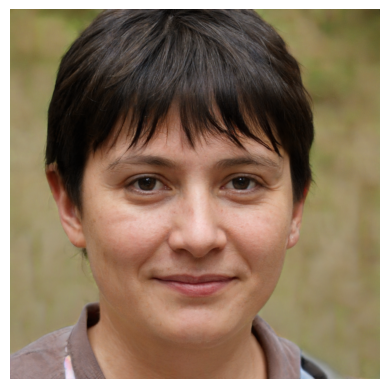

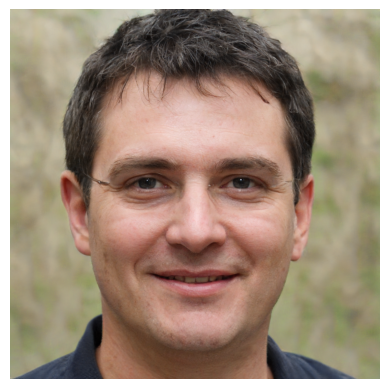

In [23]:
att1= np.array([0,0,0,0,0,0,0,26])
att2= np.array([0,0,0,0,0,0,0,-6])
compare(att1, att2, 22,22, 22)
# 1st-->
# 2nd vec--> gender change random seed 22,22,22
# 3rd vec --> age variation 22,22,22
# 4th vector --> pose variation 22
# 5th vector --> hair variation 22
# 6th vector  --> -ive direction age  positivr direction gender
# 7th vector  --> entangled
# 8thh vector --> smile, age small in positive direction

### Furthur Improvement
##### We have modified our architecture via loss function
###### Initially we have used MSE b/w latent vector predicted by mapping network and original latent vector from which these attributes are sampled
###### In our current approach we have also applied ID loss(from microsoft), which is loss beetween image generated by predicted latent vector by mapping network and image generated by original latent vector

### Architecture 2 with using ID loss

## Implementation of ID loss

In [24]:
!git clone https://github.com/orpatashnik/StyleCLIP.git

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 778 (delta 119), reused 105 (delta 105), pack-reused 618
Receiving objects: 100% (778/778), 193.81 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [25]:
import torch
from torch import nn
sys.path.insert(0, "/content/StyleCLIP")
from models.facial_recognition.model_irse import Backbone


class IDLoss(nn.Module):
    def __init__(self):
        super(IDLoss, self).__init__()
        # print('Loading ResNet ArcFace')
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        self.facenet.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset/model_ir_se50.pth'))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        self.facenet.cuda()
        # self.opts = opts

    def extract_feats(self, x):
        if x.shape[2] != 256:
            x = self.pool(x)
        x = x[:, :, 35:223, 32:220]  # Crop interesting region
        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y):
        n_samples = y.shape[0]
        y_feats = self.extract_feats(y)  # Otherwise use the feature from there
        y_hat_feats = self.extract_feats(y_hat)
        y_feats = y_feats.detach()
        loss = 0
        sim_improvement = 0
        count = 0
        for i in range(n_samples):
            diff_target = y_hat_feats[i].dot(y_feats[i])
            loss += 1 - diff_target
            count += 1

        return loss / count


###### We have using same mapping networks in both the architecture for fair comparison

In [36]:
network_modified = MappingNetwork(z_dim=529, c_dim=512, w_dim=512, num_layers=8)
device = torch.device('cuda') # specify GPU as the device
network_modified = to_device(network_modified, device) #sending to device

## Training loop

In [27]:
def train(predict_vec, real_vec, predicted_img, real_img, optimizer):
    optimizer.zero_grad()
    loss1_obj= nn.MSELoss()
    loss2_obj= IDLoss()
    loss= loss1_obj(predict_vec, real_vec) + loss2_obj(predicted_img, real_img)
    loss.backward()
    optimizer.step()
    return loss.item()

## Fit function

In [28]:
def fit(epochs, lr):
    torch.cuda.empty_cache()
    optimizer= torch.optim.Adam(network_modified.parameters(), lr=lr, betas=(0.1, 0.999))
    losses_g = []
    for epoch in range(epochs):
        # torch.cuda.empty_cache()
        for i in range(1000):
            vector= torch.cat((torch.randn(512,device=device), attribute[i,:].reshape(8),light[i,:].reshape(9) ), axis=0)

            predicted_vec= network_modified.forward(vector.float()).reshape(1,512)
            real_vec = torch.from_numpy(latent_list[i][0,0]).float().to(device).reshape(1,512)

            real_image = generate_image(device, G, real_vec.cpu().detach().numpy())
            real_image = np.array(real_image)
            real_image = torch.from_numpy(real_image.reshape(1,3,1024,1024)).to("cuda:0").float()

            # here the change comes
            predicted_image = generate_image(device, G, predicted_vec.cpu().detach().numpy())
            predicted_image = np.array(predicted_image)
            predicted_image = torch.from_numpy(predicted_image.reshape(1,3,1024,1024)).to("cuda:0").float()

            loss= train(predicted_vec ,real_vec , predicted_image, real_image, optimizer)
        print("loss is", loss)
        # losses_g.append(loss)
    return losses_g

In [29]:
lr = 0.0001
epochs = 1

In [30]:
fit(epochs, lr)

loss is 0.09131813049316406


[]

In [31]:
torch.save(network_modified.state_dict(), 'modified_model_weights.pth')

## Testing

###### Function for image generation with conditioning of attributes

In [32]:
def compare(att1, att2, i,j, seed):
  att1=torch.Tensor(att1).float()
  att1= att1.to('cuda:0')
  att2=torch.Tensor(att2).float()
  att2= att2.to('cuda:0')
  p1= torch.randn(512, device=device)
  p2= torch.randn(512, device=device)
  vector1= torch.cat((p1, att1.reshape(8),i.reshape(9) ), axis=0).reshape(1,529)
  vector2= torch.cat((p2, att2.reshape(8),j.reshape(9)), axis=0).reshape(1,529)
  z1= network_modified(vector1).reshape(1,512)
  z2= network_modified(vector2).reshape(1,512)
  # print(z1-z2)
  print("aur ye hai oroginal")
  # print(p1-p2)
  img1 = generate_image(device, G, z1.cpu().detach().numpy())

  img2 = generate_image(device, G, z2.cpu().detach().numpy())


  im1 = generate_image(device, G, p1.reshape(1,512).cpu().detach().numpy())
  im2 = generate_image(device, G, p2.reshape(1,512).cpu().detach().numpy())

  display_image(img1)

  display_image(img2)
  display_image(im1)
  display_image(im2)


# Once more

In [33]:
import torch
import torch.nn as nn

class MappingNetwork(nn.Module):
    def __init__(self, z_dim, c_dim, w_dim, num_layers):
        super(MappingNetwork, self).__init__()
        self.num_layers = num_layers
        self.fc_layers = nn.ModuleList()

        # Input layer
        self.fc_layers.append(nn.Linear(z_dim, w_dim))

        # Hidden layers
        for i in range(num_layers-1):
            in_dim = w_dim if i == 0 else c_dim
            out_dim = w_dim
            self.fc_layers.append(nn.Linear(in_dim, out_dim))

        # Activation function
        self.lrelu = nn.LeakyReLU(negative_slope=2)

    def forward(self, z):
        # Applying input layer
        h = self.lrelu(self.fc_layers[0](z))

        # Applying hidden layers
        for i in range(1, self.num_layers):
            h = self.lrelu(self.fc_layers[i](h))

        return h


In [34]:
network_modified = MappingNetwork(z_dim=529, c_dim=512, w_dim=512, num_layers=8)
device = torch.device('cuda') # specify GPU as the device
network_modified = to_device(network_modified, device) #sending to device

aur ye hai oroginal


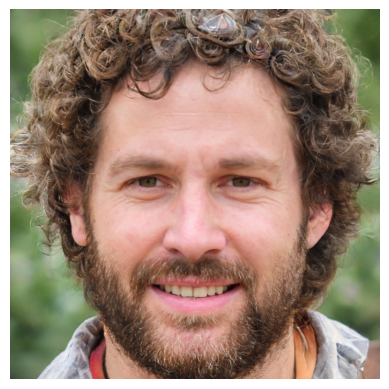

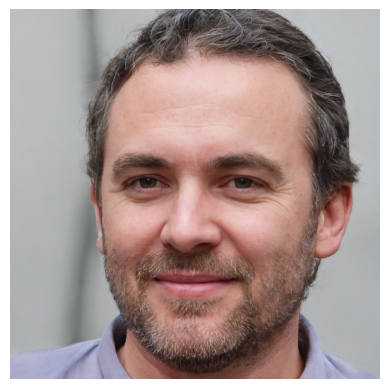

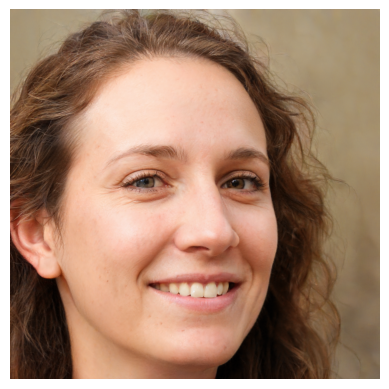

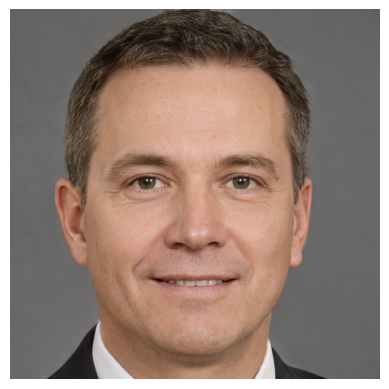

In [35]:
att1= np.random.randn(8)
att2= np.random.randn(8)
# att1= np.array([1,3.0,0,0,0,0,0,0])
# att2= np.array([0,0,0,0,0,0,0,0])
compare(att1, att2,torch.randn(9, device=device),torch.randn(9, device=device), 47)